In [2]:
import matplotlib.pylab as plt
import numpy as np
import zlib
import glob
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from generator_class import DataGenerator
from tensorflow.keras.optimizers import SGD
import json
import argparse
import pandas as pd
#GPU/CPU Selection
gpu_setting = 'y'

from eval_utils import *

2024-02-08 16:49:10.675878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from matplotlib.colors import LogNorm

In [1]:
from scipy.stats import beta, binomtest

from sklearn.metrics import confusion_matrix

In [5]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')

## Training history

In [6]:
history_file = 'CNN/ResNet_20240204_training_history.json'
f = open(history_file)
# returns JSON object as 
# a dictionary
hst = json.load(f)
f.close()


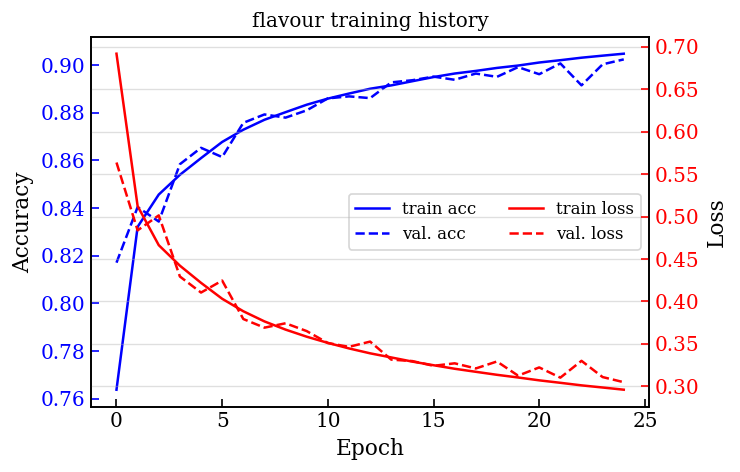

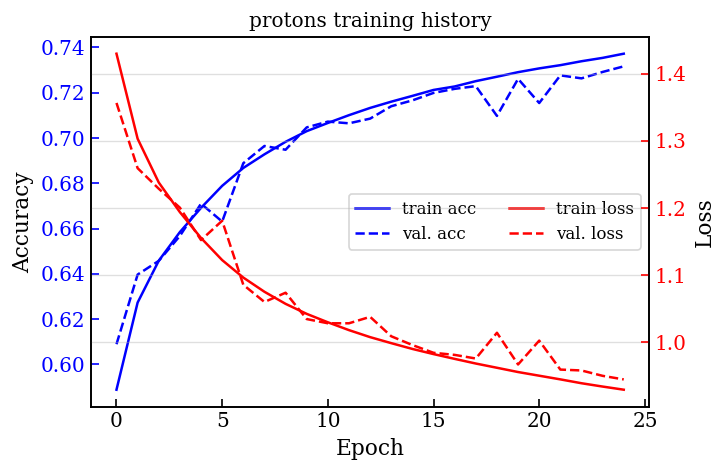

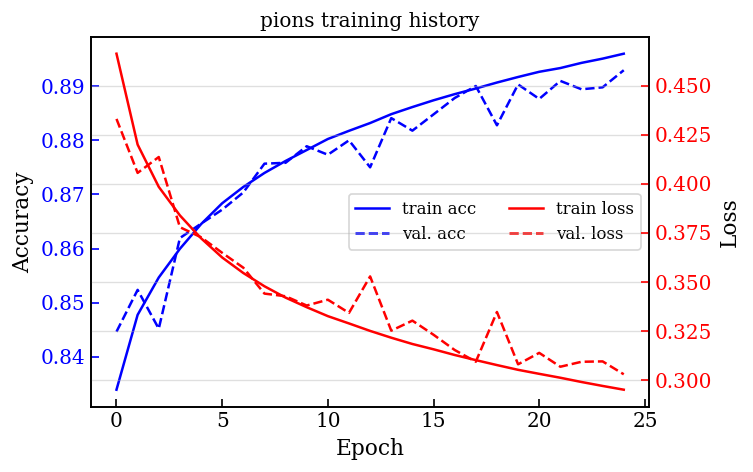

In [7]:
things_to_plot = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
things_to_plot = ['flavour', 'protons', 'pions']
for thing_to_plot in things_to_plot:
    fig, ax = plt.subplots()
    ax.tick_params('y', colors='b')
    ax.set(ylabel='Accuracy', xlabel='Epoch')
    acc = plt.plot(hst['%s_accuracy'%(thing_to_plot)], c='b', ls='-', label='train acc')
    valacc = plt.plot(hst['val_%s_accuracy'%(thing_to_plot)], c='b', ls='--', label='val. acc')
    
# Get second axis
    ax2 = ax.twinx()
    ax2.tick_params('y', colors='r')
    ax2.set(ylabel='Loss')
    loss = plt.plot(hst['%s_loss'%(thing_to_plot)], c='r', ls='-', label='train loss')
    valloss = plt.plot(hst['val_%s_loss'%(thing_to_plot)], c='r', ls='--', label='val. loss')
    # plt.ylim(0.25,.9)

    lns = acc+valacc+loss+valloss
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='center right', ncol=2)
    # plt.legend(loc='center right', ncol=2)
    plt.xlabel('epoch')
    plt.grid()
    plt.title(thing_to_plot+' training history')
    plt.savefig('model_eval_plots/%s/history_%s.pdf'%(model_name, thing_to_plot))
    plt.show()

## Evaluating test sample

In [8]:
model_name = 'ResNet_20240204' # 'ResNet_20240119_3output' # 'ResNet_v2_20240115_6layers_test'
os.makedirs('model_eval_plots/%s'%(model_name), exist_ok=True)
tests = pd.read_pickle('CNN/%s_corr_test_predictions.pkl'%(model_name))

In [9]:
test_data = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/full_statistics_testset.pkl')


In [6]:
# test_data_w_angle = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_10_11_12_b_df_testset.pkl')
# test_data = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_urllist_0_1_2_10_11_12_df_testset.pkl')
# test_data['LepAngle'] = test_data_w_angle['LepAngle']

In [13]:
# full outputs 
cls_tasks = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
output_options = [3,4,4,4,4,2]
colors = [ 'green','crimson', 'navy', 'mediumorchid',]
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 
true_meta = test_data.iloc[:len(pred[0])]

In [14]:
labels_flavour = ['NC', '$\\nu_e$ CC', '$\\nu_{\\mu}$ CC']
labels_n_particles = ['N=0', 'N=1', 'N=2', 'N=3+']
labels_is_anti = ['$\\nu$', '$\\bar{\\nu}$']

key_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_n_particles,
                 'pizeros': labels_n_particles,
                 'neutrons': labels_n_particles,
                 'is_antineutrino': labels_is_anti}

## 3 output option

In [15]:
# 3 output option 
cls_tasks = ['flavour', 'protons', 'pions']
output_options = [3,4,2]
colors = [ 'green','crimson', 'navy', 'mediumorchid',]
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 
true_meta = test_data.iloc[:len(pred[0])]

In [46]:
savefig = True


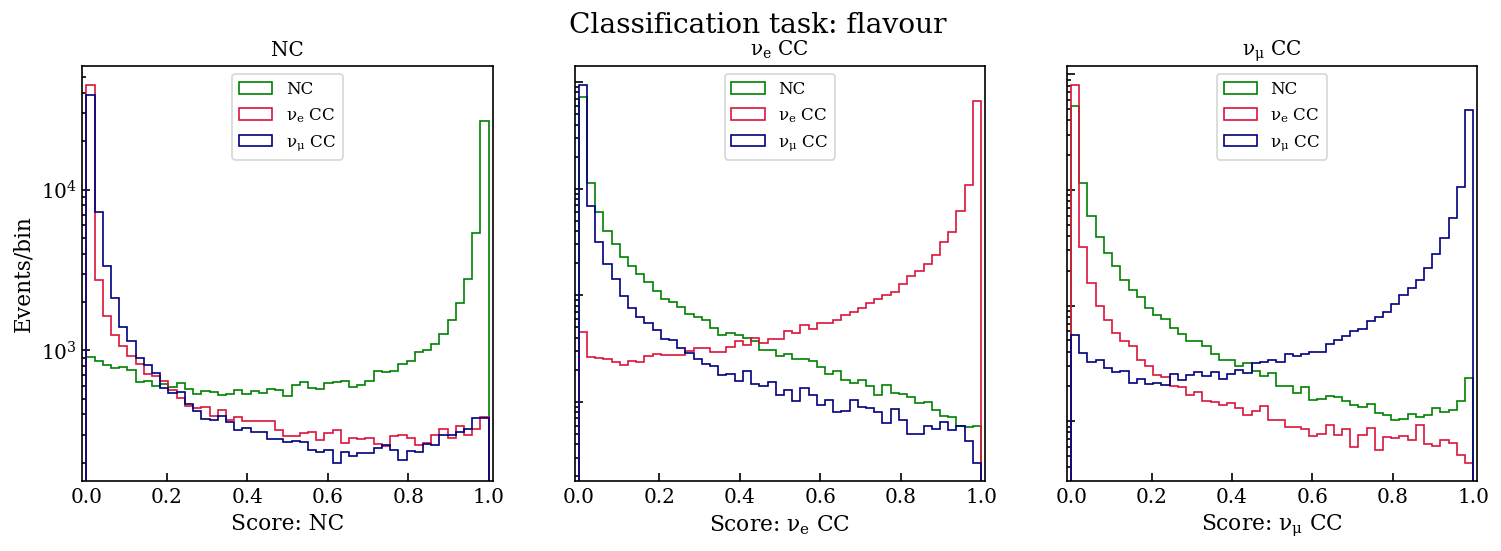

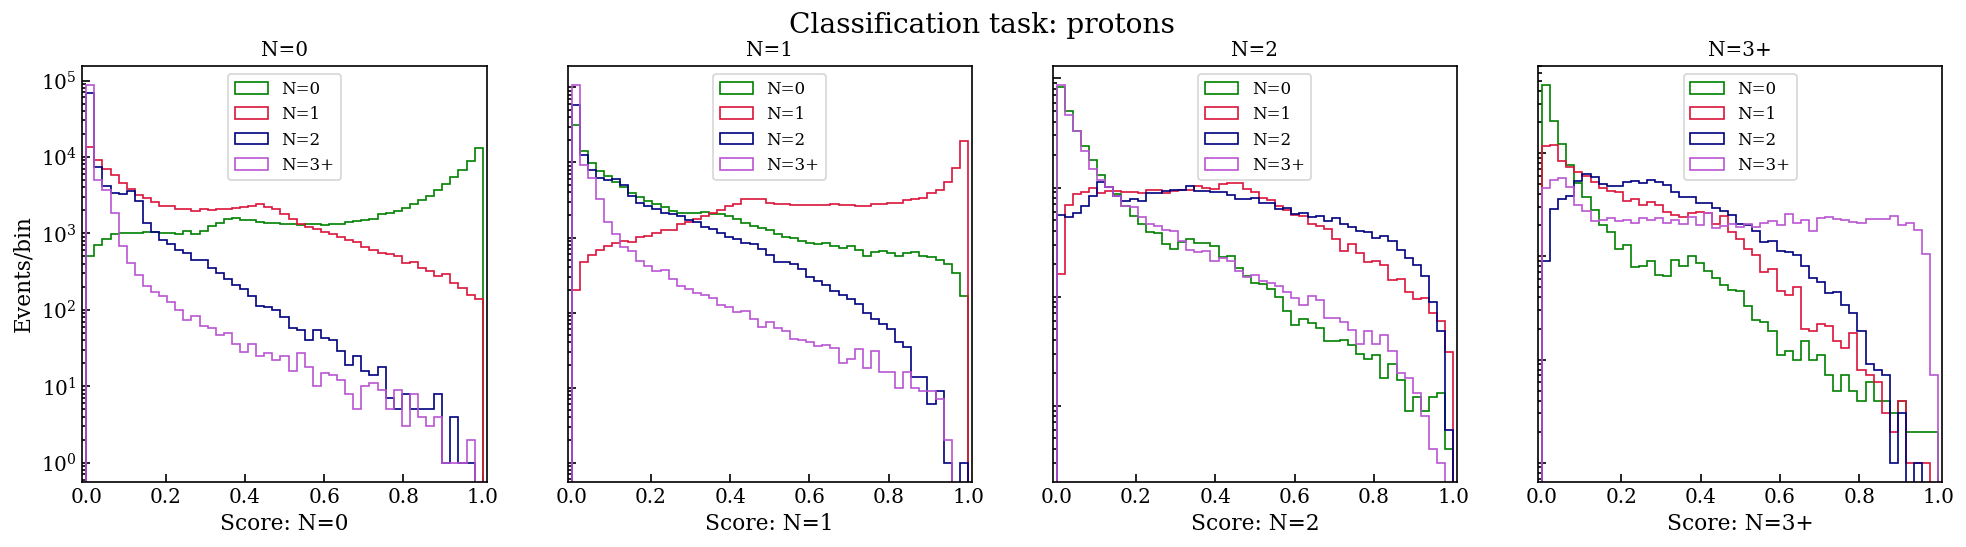

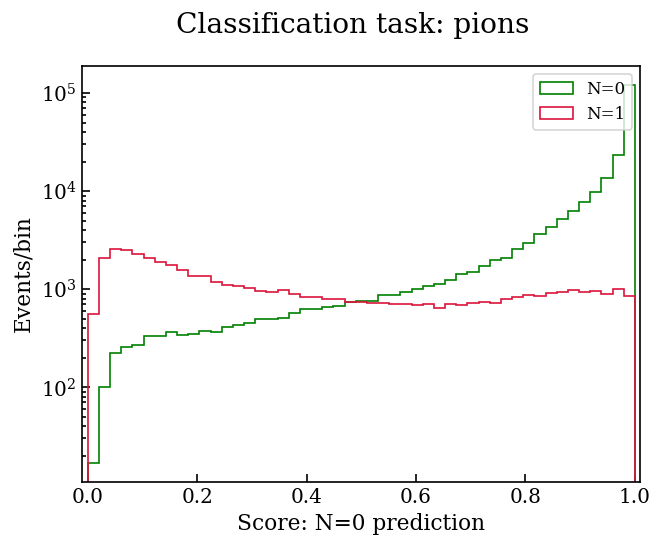

In [47]:
for cls_task in cls_tasks:
# cls_task = 'is_antineutrino' 
    num_in_pred = output_options[cls_tasks.index(cls_task)]
    class_options = np.arange(0, num_in_pred)
    cls_labels = key_labels[cls_task]
    
    if num_in_pred >2: 
        fig, axs = plt.subplots(1, len(class_options), figsize=(5*len(class_options),4.5))
        for cls, ax in zip(class_options, axs.flat):
            these_preds = pred[cls_tasks.index(cls_task)]
            for i in class_options:
                ax.hist(these_preds[true[cls_task]==cls][:,i], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[i], color=colors[i])
                
            ax.legend(loc='upper center')
            ax.set(xlabel='Score: %s'%(cls_labels[cls]), ylabel='Events/bin', 
                   title=cls_labels[cls], 
                   xlim=(-0.01, 1.01), 
                   yscale='log', 
                  )
        
        for ax in axs.flat:
            ax.label_outer()
        fig.suptitle('Classification task: %s'%(cls_task))
        plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show()
    
    else: 
        fig, ax = plt.subplots(1, figsize=(6,4.5))
        for cls in class_options:
            these_preds = pred[cls_tasks.index(cls_task)]
            
            ax.hist(these_preds[true[cls_task]==cls][:,0], bins=np.linspace(0,1,50), histtype='step', label=cls_labels[cls], color=colors[cls])
        ax.legend(loc='upper right')
        ax.set(xlabel='Score: %s prediction'%(cls_labels[0]), ylabel='Events/bin', 
               # title="Class, 
               xlim=(-0.01, 1.01), 
               yscale='log', 
              )
        fig.suptitle('Classification task: %s'%(cls_task))
        # plt.xlim(0,1)
        if savefig: 
            plt.savefig('model_eval_plots/%s/%s_predictions.pdf'%(model_name,cls_task))
        plt.show() 

In [18]:
def get_pred_class(pred_scores):
    if pred_scores.shape[1] == 1: 
        pred_class = np.int32(pred_scores+.5) #messy I know but they do 0-0.99 as 0 and 1-1.99 as 1. 
    else: 
        pred_class = np.argmax(pred_scores, axis=1)
    return pred_class

In [19]:
def calc_conf_int(confusion_matrix):
    ###
    # Calculate confidence intervals on the confusion matrix values.
    ###
    confidence_interval = np.zeros((confusion_matrix.shape[0],confusion_matrix.shape[1],2))
    for i in range(confusion_matrix.shape[1]):
        all_trials = np.sum(confusion_matrix[:,i])
        for j in range(confusion_matrix.shape[0]):
            successes = confusion_matrix[j,i]
            interval = beta.interval(0.68,successes+0.5,all_trials-successes+0.5,loc=0,scale=all_trials)
            if confusion_matrix[j,i] >= 1:
                confidence_interval[j,i,:] = [interval[1]-confusion_matrix[j,i], confusion_matrix[j,i]-interval[0]]
            else:
                confidence_interval[j,i,:] = [interval[1]-confusion_matrix[j,i],0]
                
    return confidence_interval


In [20]:
def plot_cm(confusion_matrix):
    confusion_matrix_t = confusion_matrix.T
    nclass = confusion_matrix_t.shape[0]
    fig, ax = plt.subplots(figsize=(1.5*nclass,1.5*nclass), facecolor='white')

    im = ax.imshow(confusion_matrix_t, norm=LogNorm(vmin=1.0, vmax=np.max(confusion_matrix_t)), cmap="YlGn", zorder=10)
    confidence_interval = calc_conf_int(confusion_matrix_t)
    for i in range(nclass):

        all_counts = np.sum(confusion_matrix_t[:,i])

        for j in range(nclass):

            percent = np.nan_to_num(100*confusion_matrix_t[j,i]      / all_counts)
            plus    = np.nan_to_num(100*confidence_interval[j,i,0] / all_counts)
            minus   = np.nan_to_num(100*confidence_interval[j,i,1] / all_counts)

            if percent == 100:
                text = ax.text(i, j, r'$100^{+0}_{-%0.3f}$%%' % (minus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

            elif percent == 0:
                text = ax.text(i, j, r'$0^{+%0.3f}_{-0}$%%' % (plus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

            else:
                text = ax.text(i, j, r'$%0.3f^{+%0.3f}_{-%0.3f} $%%' % (percent,plus,minus), ha="center", va="center", color=color_choice, fontsize=10, zorder=20)

    ax.set_axisbelow(True)
    ax.set_xticks(np.arange(0,nclass,1))
    ax.set_yticks(np.arange(0,nclass,1))
    labels = ['other', 'S1', 'S2'] if nclass==3 else ['S1', 'S2'] 
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12, ha='right', va='center')
    plt.xlim(-0.5,nclass-0.5)
    plt.ylim(nclass-0.5,-0.5)
    ax.set_xlabel('True Class', fontsize=12)
    ax.set_ylabel('Predicted Class', fontsize=12)
    # plt.savefig('confusion_matrix.png', bbox_inches='tight')
    # plt.show()

/tmp/ipykernel_547/538507315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)
2024-01-26 15:30:57.302550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-26 15:30:57.331675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-26 15:30:57.332038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative

3


2024-01-26 15:30:57.332833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 15:30:57.340617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-26 15:30:57.341002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-26 15:30:57.341294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

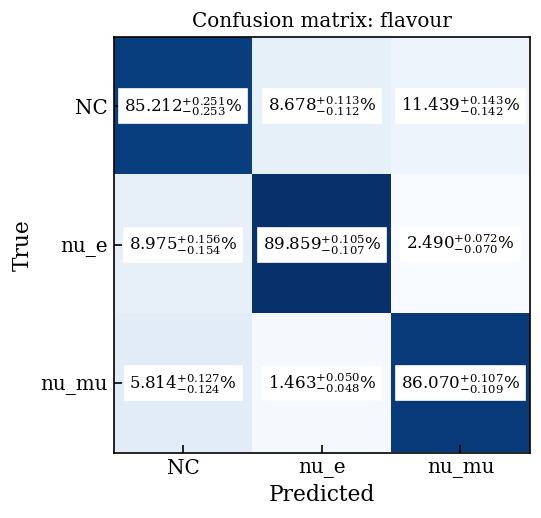

4


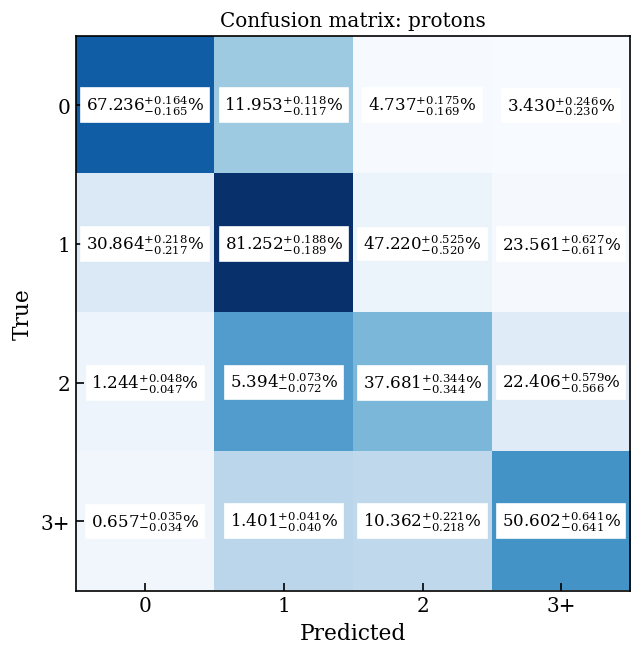

2


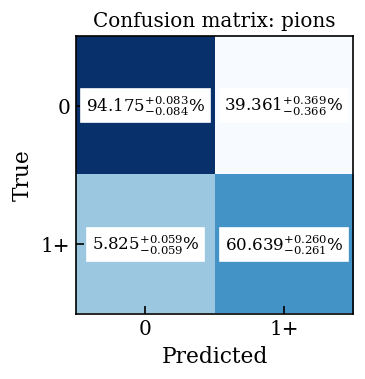

In [17]:
output_names=['flavour','protons','pions']
test_labels = test_data[output_names]
test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)

# test_eval = model.evaluate(test_generator, verbose=4)
# pred

labels_flavour = ['NC', 'nu_e', 'nu_mu']
labels_n_particles = ['0', '1', '2', '3+']
labels_pi = ['0','1+']    
conmat_axis_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_pi,}

for i, ( predd, key) in enumerate(zip( pred, output_names)):
    num_labels = output_options[i]
    if num_labels ==1: num_labels = 2
    pred_classes = get_pred_class(predd)
    print(num_labels)
    con_mat = tf.math.confusion_matrix(np.asarray(test_labels[key][:len(predd)]), pred_classes, num_classes = num_labels)
    con_mat_norm = [con_mat[i]/sum(con_mat[i])*100 for i in range(len(con_mat))]
    con_mat_norm = np.round(con_mat_norm, 2)
    confidence_interval = calc_conf_int(np.asarray(con_mat))

    fig, ax = plt.subplots(figsize=(1.5*num_labels,1.5*num_labels), facecolor='white')
    for i in range(len(con_mat)):
        all_counts = np.sum(con_mat[i,:])
        for j in range(len(con_mat[i])):
            percent = np.nan_to_num(100*con_mat[i,j]      / all_counts)
            plus    = np.nan_to_num(100*confidence_interval[i,j,0] / all_counts)
            minus   = np.nan_to_num(100*confidence_interval[i,j,1] / all_counts)
    
    
            # plt.text(j-.3, i+.075, str(np.round(con_mat_norm[i][j], 1))+'%', c='k', backgroundcolor='w', fontsize=10)
            if percent == 100:
                text = ax.text(i, j, r'$100^{+0}_{-%0.3f}$%%' % (minus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
        
            elif percent == 0:
                text = ax.text(i, j, r'$0^{+%0.3f}_{-0}$%%' % (plus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
        
            else:
                text = ax.text(i, j, r'$%0.3f^{+%0.3f}_{-%0.3f} $%%' % (percent,plus,minus), ha="center", va="center",
                               c='k', backgroundcolor='w', fontsize=10, zorder=20)
    

    ax.imshow(con_mat_norm, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    labels = conmat_axis_labels[key]
    plt.xticks(np.arange(num_labels), labels)
    plt.yticks(np.arange(num_labels), labels)
    # plt.colorbar(label='Percent of True Values Predicted')
    plt.title('Confusion matrix: %s'%(key))
    ### CHANGE PATH
    # plt.savefig('/home/sophiaf/Classification-with-ML/neutrino-classification/CNN/plots/'+args.test_name+'_con_mat_'+key+'.pdf')
    plt.show()

### Tried and works version: 

/tmp/ipykernel_4213/2476183009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)
2024-02-08 16:50:34.205905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


3


2024-02-08 16:50:34.233138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-08 16:50:34.233416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-08 16:50:34.234693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 16:50:34.241150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

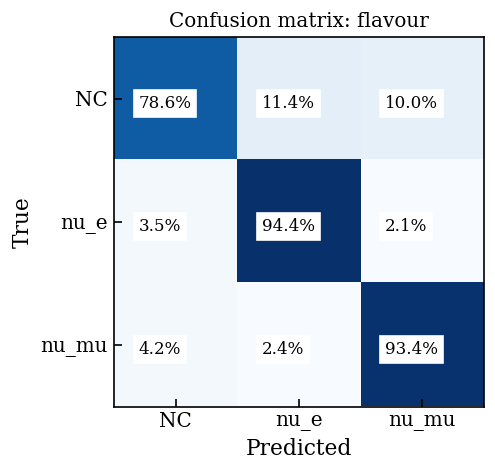

4


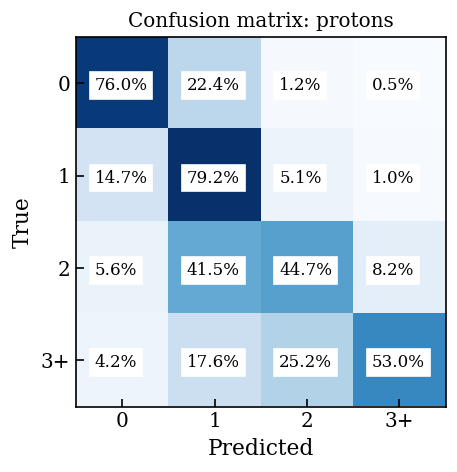

2


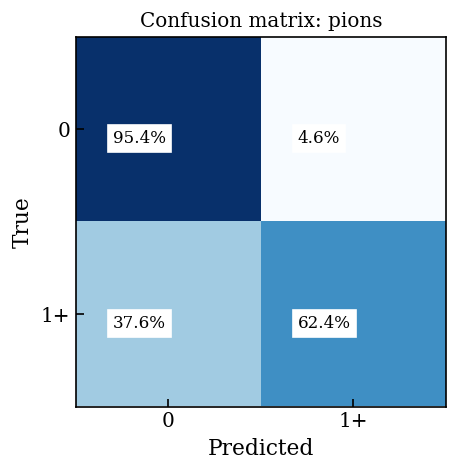

In [21]:
output_names=['flavour','protons','pions']
test_labels = test_data[output_names]
test_labels['pions'] = np.clip(test_labels['pions'], 0, 1)

# test_eval = model.evaluate(test_generator, verbose=4)
# pred

labels_flavour = ['NC', 'nu_e', 'nu_mu']
labels_n_particles = ['0', '1', '2', '3+']
labels_pi = ['0','1+']    
conmat_axis_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_pi,}

for i, ( predd, key) in enumerate(zip( pred, output_names)):
    num_labels = output_options[i]
    if num_labels ==1: num_labels = 2
    pred_classes = get_pred_class(predd)
    print(num_labels)
    con_mat = tf.math.confusion_matrix(np.asarray(test_labels[key][:len(predd)]), pred_classes, num_classes = num_labels)
    con_mat_norm = [con_mat[i]/sum(con_mat[i])*100 for i in range(len(con_mat))]
    con_mat_norm = np.round(con_mat_norm, 2)
    
    plt.figure()
    for i in range(len(con_mat)):
        for j in range(len(con_mat[i])):
            plt.text(j-.3, i+.075, str(np.round(con_mat_norm[i][j], 1))+'%', c='k', backgroundcolor='w', fontsize=10)
    plt.imshow(con_mat_norm, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    labels = conmat_axis_labels[key]
    plt.xticks(np.arange(num_labels), labels)
    plt.yticks(np.arange(num_labels), labels)
    # plt.colorbar(label='Percent of True Values Predicted')
    plt.title('Confusion matrix: %s'%(key))
    ### CHANGE PATH
    plt.savefig('/home/sophiaf/Classification-with-ML/neutrino-classification/CNN/plots/'+model_name+'_con_mat_'+key+'.pdf')
    plt.show()

In [15]:
mask_1p_0pi = true['flavour']!=0 #not NC 
mask_1p_0pi &= true['protons']==1
mask_1p_0pi &= true['pions']==0
cc_1p_0pi = true[mask_1p_0pi]
print(sum(mask_1p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_1p_0pi["is_antineutrino"]==0)/len(cc_1p_0pi)))

45454


KeyError: 'is_antineutrino'

In [14]:
mask_0p_0pi = true['flavour']!=0 #not NC 
mask_0p_0pi &= true['protons']==0
mask_0p_0pi &= true['pions']==0
cc_0p_0pi = true[mask_0p_0pi]
print(sum(mask_0p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_0p_0pi["is_antineutrino"]==0)/len(cc_0p_0pi)))

32220
Fraction of nu/(nu+nubar): 0.60


In [15]:
mask_2p_0pi = true['flavour']!=0 #not NC 
mask_2p_0pi &= true['protons']==2
mask_2p_0pi &= true['pions']==0
cc_2p_0pi = true[mask_2p_0pi]
print(sum(mask_2p_0pi))
print('Fraction of nu/(nu+nubar): %.2f'%(sum(cc_2p_0pi["is_antineutrino"]==0)/len(cc_2p_0pi)))

9092
Fraction of nu/(nu+nubar): 0.94


We're interested in keeping the CC. It looks like we can keep CC flavor-agnostic in this case. 

In [15]:
def cc_mask(preds, bound):
    nue_cc_pass = preds[:,1]>bound
    numu_cc_pass = preds[:,2]>bound
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    return cc_pass

def cc_nue_mask(preds, bound): 
    nue_cc_pass = preds[:,1]>bound
    return nue_cc_pass

def cc_numu_mask(preds, bound): 
    numu_cc_pass = preds[:,2]>bound
    return numu_cc_pass

def nc_mask(preds, bound):
    not_nc = preds[:,0]<bound
    return not_nc    

In [16]:
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 

In [17]:
flav_preds = pred[0]
cc_score = np.sum(flav_preds[:,1:], axis=1)
nc_score = flav_preds[:,0]

In [18]:
mask_nc = true['flavour']==0
mask_cc = true['flavour']>0

In [20]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_cc = true[mask_cc]

for i, x in enumerate(xs): 
    nue_cc_pass = flav_preds[:,1]>x
    numu_cc_pass = flav_preds[:,2]>x
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

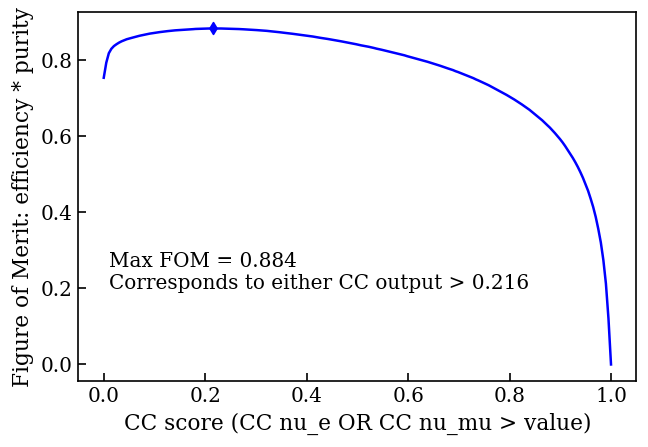

In [23]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('Figure of Merit: efficiency * purity')
plt.xlabel('CC score (CC nu_e OR CC nu_mu > value)')
plt.text(0.01, 0.2, 'Max FOM = %.3f \nCorresponds to either CC output > %.3f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.savefig('model_eval_plots/%s/fom.pdf'%(model_name))
plt.show()


/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


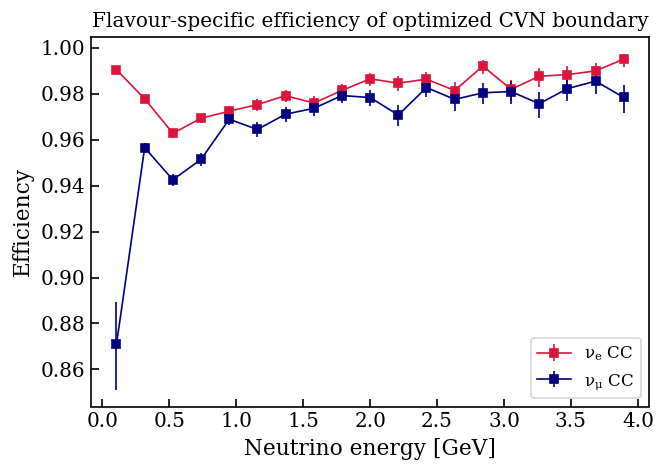

In [82]:
# efficiency as a function of energy 
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):

        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = cc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/n
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i] = np.abs(sigma_eff- effs[i])
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('Neutrino energy [GeV]')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/efficiency_energy.pdf'%(model_name))
plt.show()        

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


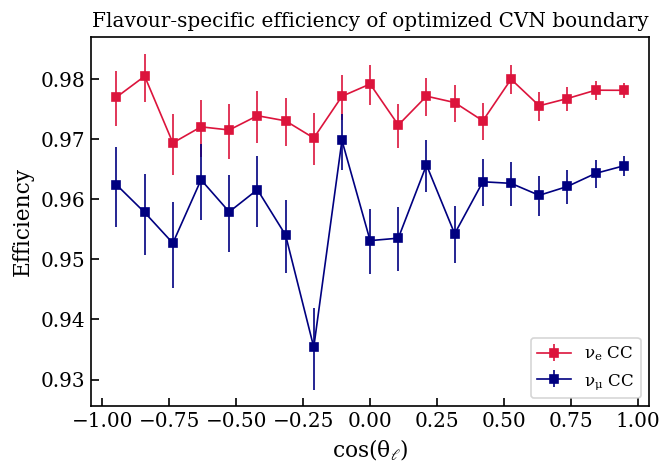

In [83]:
# efficiency as a function of lepton angle  
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(-1,1,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = np.cos(true_meta['LepAngle']) >= e_min
        e_mask &= np.cos(true_meta['LepAngle']) < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = cc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/(n+1e-2)
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i] = np.abs(sigma_eff- effs[i])
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('cos($\\theta_{\\ell}$)')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/efficiency_theta_l.pdf'%(model_name))

plt.show()        

In [36]:
xs = np.linspace(0,1,200)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)
all_true_nc = true[mask_nc]

for i, x in enumerate(xs): 
    cc_pass = flav_preds[:,0]<x
    cc_true_pass = np.logical_and(cc_pass, true['flavour']>0)
    efficiency[i] = sum(cc_true_pass)/len(all_true_cc)
    purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

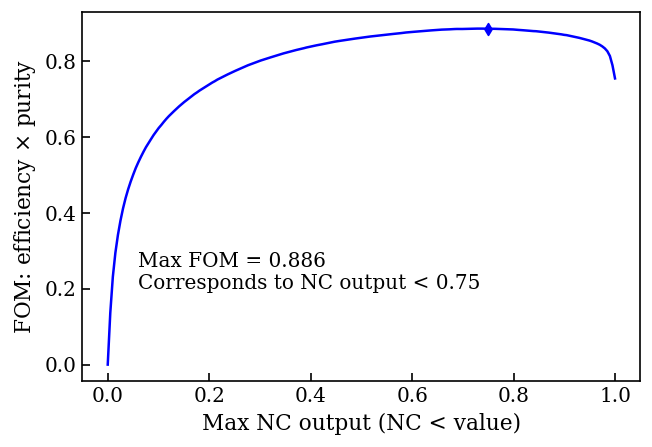

In [37]:
fom = efficiency*purity
plt.plot(xs, fom)
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('FOM: efficiency $\\times$ purity')
plt.xlabel('Max NC output (NC < value)')
plt.text(0.06, 0.2, 'Max FOM = %.3f \nCorresponds to NC output < %.2f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
# plt.savefig('model_eval_plots/%s/fom_nc.pdf'%(model_name))
plt.show()

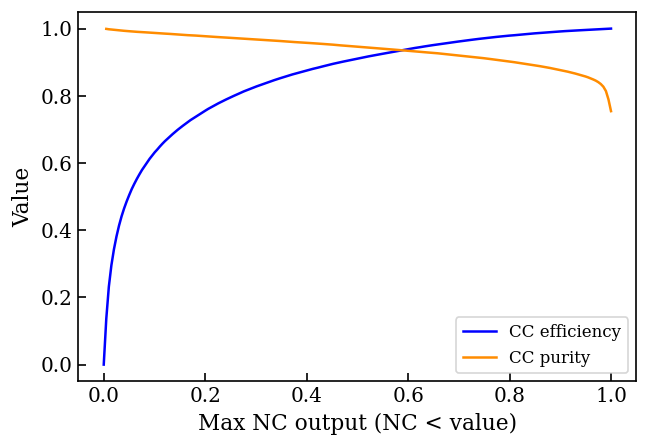

In [34]:
plt.plot(xs, efficiency, label='CC efficiency')
plt.plot(xs, purity, label='CC purity')

# plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
# plt.plot(xs, purity)
plt.ylabel('Value')
plt.xlabel('Max NC output (NC < value)')
plt.legend()
# plt.ylim(0.8,1)
# plt.text(0.01, 0.2, 'Max FOM = %.3f \nCorresponds to either CC output > %.3f'%(np.max(fom), xs[np.argmax(fom)]), fontsize=12)
plt.savefig('model_eval_plots/%s/efficiency_purity_ncdef.pdf'%(model_name))
plt.show()


In [ ]:
purity[i] = sum(cc_true_pass)/(sum(cc_pass)+1e-5)

In [38]:
# efficiency as a function of energy 
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))
impurity = np.zeros_like(e_means) 

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):

        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = nc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound

        true_nc_in_e = true_in_e['flavour']==0
        pass_nc_in_e = true_nc_in_e * pred_cc_in_e
        impurity[i] = sum(pass_nc_in_e)/(sum(true_nc_in_e)+1e-5)

        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/n
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i] = np.abs(sigma_eff- effs[i])
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.errorbar(e_means, impurity, yerr = sigma_effs, 
                 label='NC-as-CC/NC$_{tot}$', color='orange', linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('Neutrino energy [GeV]')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
# plt.savefig('model_eval_plots/%s/efficiency_ncdef_energy.pdf'%(model_name))
plt.show()        

NameError: name 'nc_mask' is not defined

/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:25: RuntimeWarning: divide by zero encountered in log
  epsilon_to_the_power_of_k = k*np.log(epsilon)
/home/sophiaf/Classification-with-ML/neutrino-classification/eval_utils.py:33: RuntimeWarning: divide by zero encountered in log
  n_k_to_the_power_1_epsilon = (n - k)*np.log(1 - epsilon)


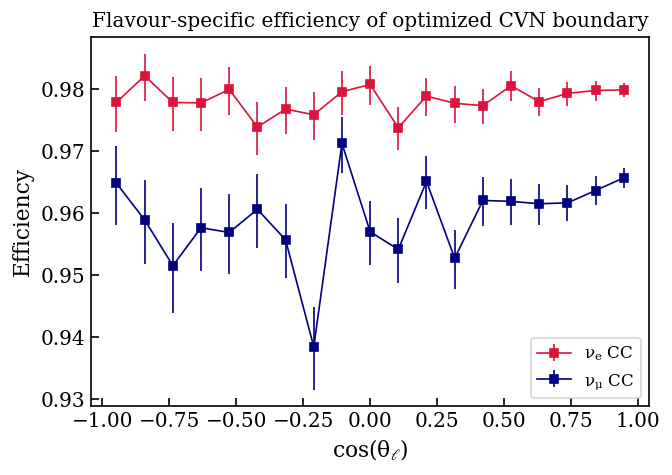

In [132]:
# efficiency as a function of lepton angle  
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(-1,1,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = np.cos(true_meta['LepAngle']) >= e_min
        e_mask &= np.cos(true_meta['LepAngle']) < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = nc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/(n+1e-2)
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i] = np.abs(sigma_eff- effs[i])
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='s')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('cos($\\theta_{\\ell}$)')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
plt.savefig('model_eval_plots/%s/ncdef_efficiency_theta_l.pdf'%(model_name))

plt.show()        

## Decision boundary on flavor 

In [27]:
def cc_mask(preds, bound):
    nue_cc_pass = preds[:,1]>bound
    numu_cc_pass = preds[:,2]>bound
    cc_pass = np.logical_or(nue_cc_pass, numu_cc_pass)
    return cc_pass

def cc_nue_mask(preds, bound): 
    nue_cc_pass = preds[:,1]>bound
    return nue_cc_pass

def cc_numu_mask(preds, bound): 
    numu_cc_pass = preds[:,2]>bound
    return numu_cc_pass

def nc_mask(preds, bound):
    not_nc = preds[:,0]<bound
    return not_nc    

In [28]:
pred = tests['pred']
true = tests['true'].iloc[:len(pred[0])] # batches cut off preds 

In [29]:
flav_preds = pred[0]

pred

In [22]:
is_nc = true['flavour']==0
is_cc_nue = true['flavour']==1
is_cc_numu = true['flavour']==2


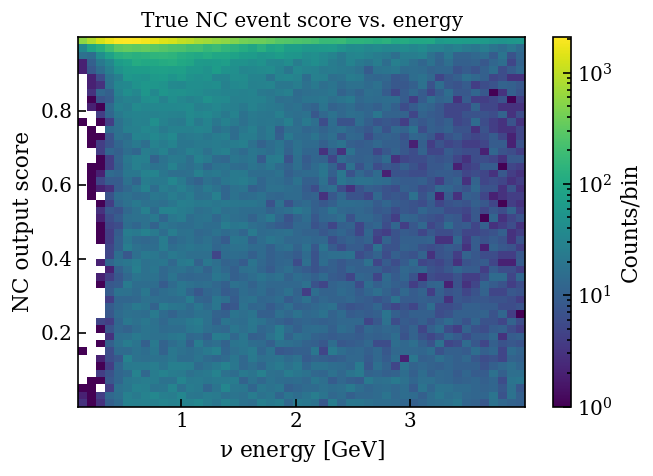

In [212]:
plt.hist2d(true_meta[is_nc]['NuEnergy'], pred[0][is_nc][:,0],bins=50,norm=LogNorm())
plt.xlabel('$\\nu$ energy [GeV]')
plt.ylabel('NC output score')
plt.title('True NC event score vs. energy') 
plt.colorbar(label="Counts/bin")
plt.savefig('model_eval_plots/%s/nc_score_vs_energy.pdf'%(model_name))
plt.show()

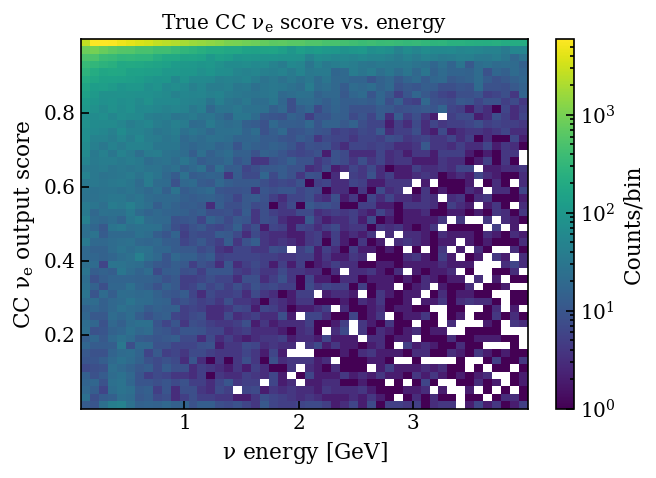

In [213]:
plt.hist2d(true_meta[is_cc_nue]['NuEnergy'], pred[0][is_cc_nue][:,1],bins=50,norm=LogNorm())
plt.xlabel('$\\nu$ energy [GeV]')
plt.ylabel('CC $\\nu_e$ output score')
plt.title('True CC $\\nu_e$ score vs. energy') 
plt.colorbar(label="Counts/bin")
plt.savefig('model_eval_plots/%s/cc_nue_score_vs_energy.pdf'%(model_name))
plt.show()

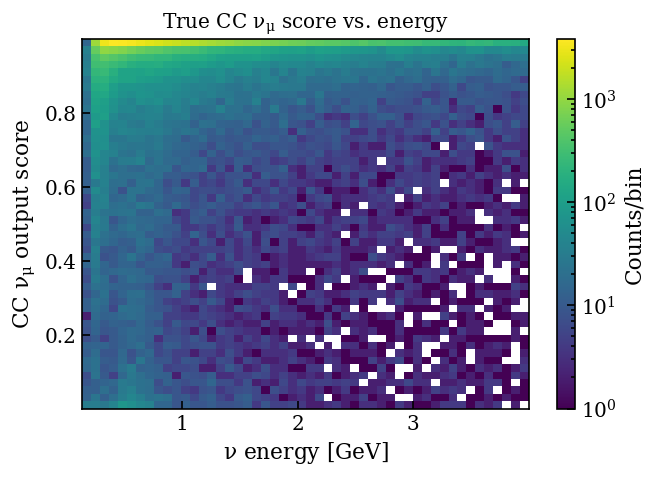

In [215]:
plt.hist2d(true_meta[is_cc_numu]['NuEnergy'], pred[0][is_cc_numu][:,2],bins=50,norm=LogNorm())
plt.xlabel('$\\nu$ energy [GeV]')
plt.ylabel('CC $\\nu_\\mu$ output score')
plt.title('True CC $\\nu_\\mu$ score vs. energy') 
plt.colorbar(label="Counts/bin")

plt.savefig('model_eval_plots/%s/cc_numu_score_vs_energy.pdf'%(model_name))
plt.show()

Algorithm: 
* if nu_e pred is > than the bound from the nu_e FOM: class as nu_e.
* if not: then if nu_mu pred is > than the bound from the nu_mu FOM: class as nu_mu
* else: class as NC. 

### Nu_e boundary 

In [238]:
use_crossing_point = False
use_max_fom = True
if use_crossing_point: decision_label = 'crossingpoint' 
if use_max_fom: decision_label = 'max_fom' 

In [193]:
xs = np.linspace(0,1,201)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)

for i, x in enumerate(xs): 
    nu_e_pass = flav_preds[:,1]>x
    is_nu_e_and_pred_nu_e = np.logical_and(is_cc_nue, nu_e_pass)
    efficiency[i] = sum(is_nu_e_and_pred_nu_e)/sum(is_cc_nue)
    purity[i] = sum(is_nu_e_and_pred_nu_e)/(sum(nu_e_pass)+1e-5)
fom = efficiency*purity

In [194]:
nue_bound_crossing = xs[np.argmin(np.abs(efficiency[2:-3]-purity[2:-3]))]
nue_bound_fom = xs[np.argmax(fom)]
if use_crossing_point:
    nue_bound = nue_bound_crossing
elif use_max_fom:
    nue_bound = nue_bound_fom

/tmp/ipykernel_4213/664433811.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Max FOM (%.3f): CC $\\nu_e$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), nue_bound_fom, purity[xs==nue_bound_fom]*100, efficiency[xs==nue_bound_fom]*100),
/tmp/ipykernel_4213/664433811.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Crossing-point: CC $\\nu_e$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(nue_bound_crossing, purity[xs==nue_bound_crossing]*100, efficiency[xs==nue_bound_crossing]*100),


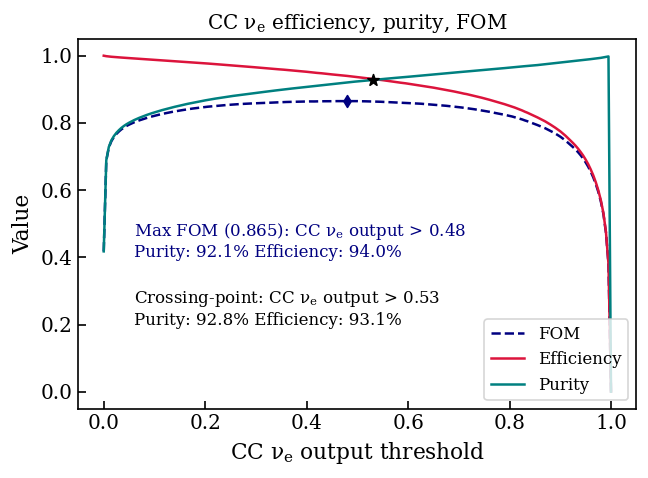

In [37]:
plt.plot(xs, fom, label='FOM', linestyle='--', marker='')
plt.plot(xs, efficiency, label='Efficiency', linestyle='-')
plt.plot(xs, purity, label='Purity')
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
plt.scatter(nue_bound_crossing, purity[xs==nue_bound_crossing], marker='*',s=50, color='k', zorder=100)

# plt.plot(xs, purity)
plt.ylabel('Value')
plt.xlabel('CC $\\nu_e$ output threshold')
plt.title('CC $\\nu_e$ efficiency, purity, FOM')
plt.text(0.06, 0.4, 
         'Max FOM (%.3f): CC $\\nu_e$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), nue_bound_fom, purity[xs==nue_bound_fom]*100, efficiency[xs==nue_bound_fom]*100),
         fontsize=10, color='navy')
plt.text(0.06, 0.2, 
         'Crossing-point: CC $\\nu_e$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(nue_bound_crossing, purity[xs==nue_bound_crossing]*100, efficiency[xs==nue_bound_crossing]*100),
         fontsize=10, color='black')

plt.legend(loc = 'lower right')
plt.savefig('model_eval_plots/%s/fom_nu_e.pdf'%(model_name))
plt.show()

### Nu_mu boundary 

In [195]:
xs = np.linspace(0,1,201)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)

for i, x in enumerate(xs): 
    nu_mu_pass = flav_preds[:,2]>x
    is_nu_mu_and_pred_nu_mu = np.logical_and(is_cc_numu, nu_mu_pass)
    efficiency[i] = sum(is_nu_mu_and_pred_nu_mu)/sum(is_cc_numu)
    purity[i] = sum(is_nu_mu_and_pred_nu_mu)/(sum(nu_mu_pass)+1e-5)
fom = efficiency*purity

In [196]:
numu_bound_crossing = xs[np.argmin(np.abs(efficiency[2:-3]-purity[2:-3]))]
numu_bound_fom = xs[np.argmax(fom)]
if use_crossing_point:
    numu_bound = numu_bound_crossing
elif use_max_fom:
    numu_bound = numu_bound_fom

/tmp/ipykernel_4213/269295527.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Max FOM (%.3f): CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), numu_bound_fom, purity[xs==numu_bound_fom]*100, efficiency[xs==numu_bound_fom]*100),
/tmp/ipykernel_4213/269295527.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Crossing-point: CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(numu_bound_crossing,


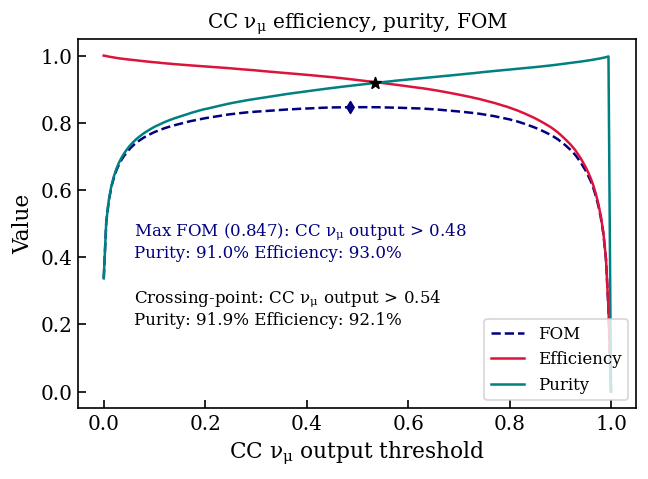

In [45]:
plt.plot(xs, fom, label='FOM', linestyle='--')
plt.plot(xs, efficiency, label='Efficiency')
plt.plot(xs, purity, label='Purity')
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
plt.scatter(numu_bound_crossing, purity[xs==numu_bound_crossing], marker='*',s=50, color='k', zorder=100)

plt.ylabel('Value')
plt.xlabel('CC $\\nu_\\mu$ output threshold')
plt.title('CC $\\nu_\\mu$ efficiency, purity, FOM')
plt.text(0.06, 0.4, 
         'Max FOM (%.3f): CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), numu_bound_fom, purity[xs==numu_bound_fom]*100, efficiency[xs==numu_bound_fom]*100),
         fontsize=10, color='navy')
plt.text(0.06, 0.2, 
         'Crossing-point: CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(numu_bound_crossing, 
                                                                                             purity[xs==numu_bound_crossing]*100, efficiency[xs==numu_bound_crossing]*100),
         fontsize=10, color='black')
plt.legend(loc = 'lower right')
plt.savefig('model_eval_plots/%s/fom_nu_mu.pdf'%(model_name))
plt.show()

In [197]:
xs = np.linspace(0,1,201)
efficiency = np.zeros_like(xs)
purity = np.zeros_like(xs)

still_to_be_classed = flav_preds[:,1]<nue_bound
for i, x in enumerate(xs): 
    nu_mu_pass = flav_preds[still_to_be_classed][:,2]>x
    is_cc_numu_stilltobeclassed = is_cc_numu[still_to_be_classed]
    is_nu_mu_and_pred_nu_mu = np.logical_and(is_cc_numu_stilltobeclassed, nu_mu_pass)
    efficiency[i] = sum(is_nu_mu_and_pred_nu_mu)/sum(is_cc_numu_stilltobeclassed)
    purity[i] = sum(is_nu_mu_and_pred_nu_mu)/(sum(nu_mu_pass)+1e-5)
fom = efficiency*purity

In [198]:
numu_bound_crossing = xs[np.argmin(np.abs(efficiency[2:-3]-purity[2:-3]))]
numu_bound_fom = xs[np.argmax(fom)]
if use_crossing_point:
    numu_bound = numu_bound_crossing
elif use_max_fom:
    numu_bound = numu_bound_fom

/tmp/ipykernel_4213/2382033550.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Max FOM (%.3f): CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), numu_bound_fom, purity[xs==numu_bound_fom]*100, efficiency[xs==numu_bound_fom]*100),
/tmp/ipykernel_4213/2382033550.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Crossing-point: CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(numu_bound_crossing,


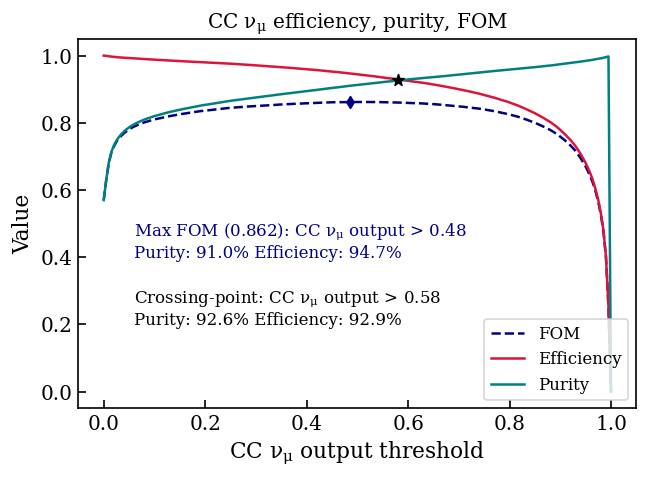

In [51]:
plt.plot(xs, fom, label='FOM', linestyle='--')
plt.plot(xs, efficiency, label='Efficiency')
plt.plot(xs, purity, label='Purity')
plt.scatter(xs[np.argmax(fom)], np.max(fom), marker='d')
plt.scatter(numu_bound_crossing, purity[xs==numu_bound_crossing], marker='*',s=50, color='k', zorder=100)

plt.ylabel('Value')
plt.xlabel('CC $\\nu_\\mu$ output threshold')
plt.title('CC $\\nu_\\mu$ efficiency, purity, FOM')
plt.text(0.06, 0.4, 
         'Max FOM (%.3f): CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(np.max(fom), numu_bound_fom, purity[xs==numu_bound_fom]*100, efficiency[xs==numu_bound_fom]*100),
         fontsize=10, color='navy')
plt.text(0.06, 0.2, 
         'Crossing-point: CC $\\nu_\\mu$ output > %.2f \nPurity: %.1f%% Efficiency: %.1f%%'%(numu_bound_crossing, 
                                                                                             purity[xs==numu_bound_crossing]*100, efficiency[xs==numu_bound_crossing]*100),
         fontsize=10, color='black')
plt.legend(loc = 'lower right')
plt.savefig('model_eval_plots/%s/fom_nu_mu_2.pdf'%(model_name))
plt.show()

### Algorithm for classification now 

In [53]:
def cc_nue_mask(preds, bound): 
    nue_cc_pass = preds[:,1]>bound
    return nue_cc_pass

def cc_numu_mask(preds, bound): 
    numu_cc_pass = preds[:,2]>bound
    return numu_cc_pass

In [231]:
numu_bound, nue_bound

(0.58, 0.53)

In [239]:
# looking at results we want to weight the purity probably a little more. 
custom_values=False

if custom_values: 
    numu_bound = .5 # .38 
    nue_bound = .5 # .38
if use_max_fom: 
    numu_bound = .485
    nue_bound = 0.48
elif use_crossing_point:
    numu_bound = .58
    nue_bound = 0.53

In [240]:
is_pred_nu_e = cc_nue_mask(flav_preds, nue_bound)
is_pred_nu_mu_prelim = cc_numu_mask(flav_preds, numu_bound)
is_pred_nu_mu = ~is_pred_nu_e * is_pred_nu_mu_prelim
is_pred_nc = ~is_pred_nu_e * ~is_pred_nu_mu
pred_masks = [is_pred_nc, is_pred_nu_e, is_pred_nu_mu]

true_cc_nu_e = true['flavour'] == 1 
true_cc_nu_mu = true['flavour'] == 2 
true_nc = true['flavour'] == 0
true_masks = [true_nc, true_cc_nu_e, true_cc_nu_mu]
# i have confirmed the three preds add up to the right number 

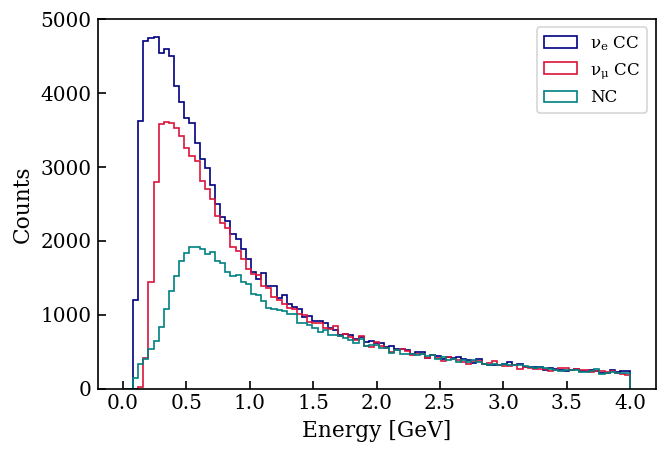

In [250]:
plt.hist(true_meta[true_cc_nu_e]['NuEnergy'], bins=np.linspace(0,4,100), histtype='step', label='$\\nu_e$ CC')
plt.hist(true_meta[true_cc_nu_mu]['NuEnergy'], bins=np.linspace(0,4,100), histtype='step', label='$\\nu_\\mu$ CC')
plt.hist(true_meta[true_nc]['NuEnergy'], bins=np.linspace(0,4,100), histtype='step', label='NC')
plt.legend()
plt.ylabel('Counts')
plt.xlabel('Energy [GeV]')
plt.savefig('energy_distribution.pdf')
plt.show()

In [241]:
# print('For crossing point method:')
print('For Max-FOM method:')
print('Overall nu_e efficiency: %.2f%%'%(sum(is_pred_nu_e*true_cc_nu_e)/sum(true_cc_nu_e)*100))
print('Overall nu_mu efficiency: %.2f%%'%(sum(is_pred_nu_mu*true_cc_nu_mu)/sum(true_cc_nu_mu)*100))
print('Overall nu_e purity: %.2f%%'%(sum(is_pred_nu_e*true_cc_nu_e)/sum(is_pred_nu_e)*100))
print('Overall nu_mu purity: %.2f%%'%(sum(is_pred_nu_mu*true_cc_nu_mu)/sum(is_pred_nu_mu)*100))
print('Overall nu_e background: %.2f%%'%(sum(is_pred_nu_e*~true_cc_nu_e)/sum(is_pred_nu_e)*100))
print('Overall nu_mu background: %.2f%%'%(sum(is_pred_nu_mu*~true_cc_nu_mu)/sum(is_pred_nu_mu)*100))


For Max-FOM method:
Overall nu_e efficiency: 93.98%
Overall nu_mu efficiency: 93.00%
Overall nu_e purity: 92.06%
Overall nu_mu purity: 91.03%
Overall nu_e background: 7.94%
Overall nu_mu background: 8.97%


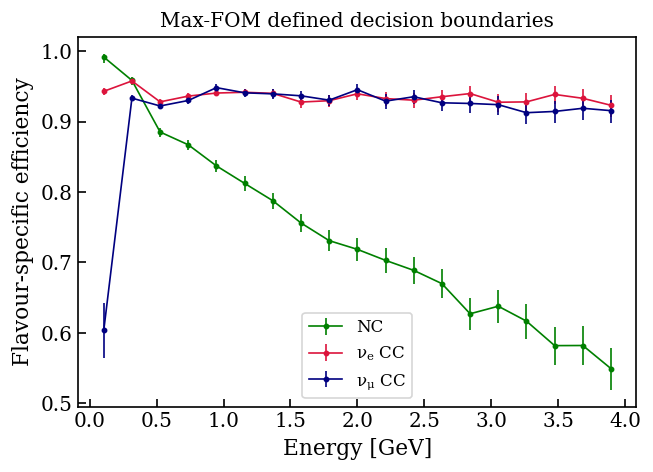

In [224]:
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros((len(e_means),3))
sigma_effs = np.zeros((2,len(e_means), 3))
purity = np.zeros((len(e_means),3)) # one purity for each flavor 

for j, (pred_mask, true_mask) in enumerate(zip(pred_masks, true_masks)):

    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask # predicted AND true events 
        n = true_mask * e_mask# total true events 
        if sum(n)>0: 
            effs[i,j] = sum(k)/(sum(n)+1e-5)#NC eff 
        else: 
            effs[i,j] = np.nan
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i,j] = np.abs(sigma_eff- effs[i,j])
    
    plt.errorbar(e_means, effs[:,j], yerr = sigma_effs[:,:,j], 
                 label=key_labels['flavour'][j], color=colors[j], linewidth=1, marker='.')
plt.legend(loc='lower center')
plt.ylabel('Flavour-specific efficiency')
plt.xlabel('Energy [GeV]')
# plt.title('Crossing-point defined decision boundaries')
# plt.title('Max-FOM defined decision boundaries')
plt.savefig('model_eval_plots/%s/efficiency_energy_3class_%s_def.pdf'%(model_name, decision_label))

plt.show()

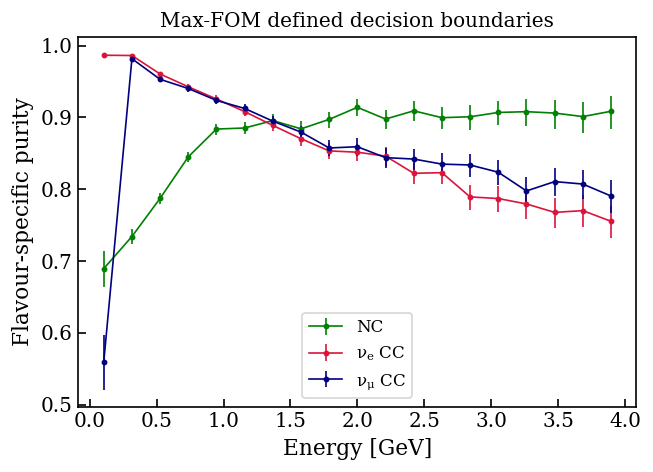

In [225]:
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
purity = np.zeros((len(e_means),3)) # one purity for each flavor 
sigma_purity = np.zeros((2,len(e_means), 3))

for j, (pred_mask, true_mask) in enumerate(zip(pred_masks, true_masks)):

    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask # predicted AND true events 
        n = pred_mask * e_mask# total PREDICTED events 
        purity[i,j] = sum(k)/sum(n)#NC eff 
        sigma_pur = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_purity[:,i,j] = np.abs(sigma_pur- purity[i,j])
    
    plt.errorbar(e_means, purity[:,j], yerr = sigma_purity[:,:,j], 
                 label=key_labels['flavour'][j], color=colors[j], linewidth=1, marker='.')
plt.legend(loc='lower center')
plt.ylabel('Flavour-specific purity')
plt.xlabel('Energy [GeV]')
# plt.title('Crossing-point defined decision boundaries')
# plt.title('Max-FOM defined decision boundaries')
plt.savefig('model_eval_plots/%s/purity_energy_3class_%s_def.pdf'%(model_name, decision_label))

plt.show()

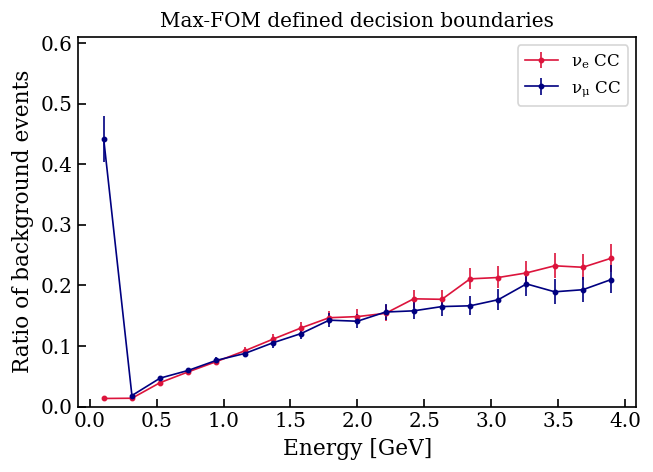

In [226]:
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
bg_fraction = np.zeros((len(e_means),3)) # one purity for each flavor 
sigma_bgs = np.zeros((2,len(e_means), 3))

for j, (pred_mask, true_mask) in enumerate(zip(pred_masks, true_masks)):
    if j==0: continue
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask # predicted AND true events 
        n = pred_mask * e_mask# total PREDICTED events 
        bg_fraction[i,j] = 1 - sum(k)/sum(n)#NC eff 
        sigma_bg = [binomtest(sum(n)-sum(k), sum(n)).proportion_ci().low, binomtest(sum(n)-sum(k), sum(n)).proportion_ci().high]
        sigma_bgs[:,i,j] = np.abs(sigma_bg- bg_fraction[i,j])
    
    plt.errorbar(e_means, bg_fraction[:,j], yerr = sigma_bgs[:,:,j], 
                 label=key_labels['flavour'][j], color=colors[j], linewidth=1, marker='.')
plt.legend(loc='upper right')
plt.ylabel('Ratio of background events')
plt.xlabel('Energy [GeV]')
plt.ylim(0,0.61)
# plt.title('Max-FOM defined decision boundaries')
# plt.title('Crossing-point defined decision boundaries')
plt.savefig('model_eval_plots/%s/bg_rate_energy_3class_%s_def.pdf'%(model_name, decision_label))

plt.show()

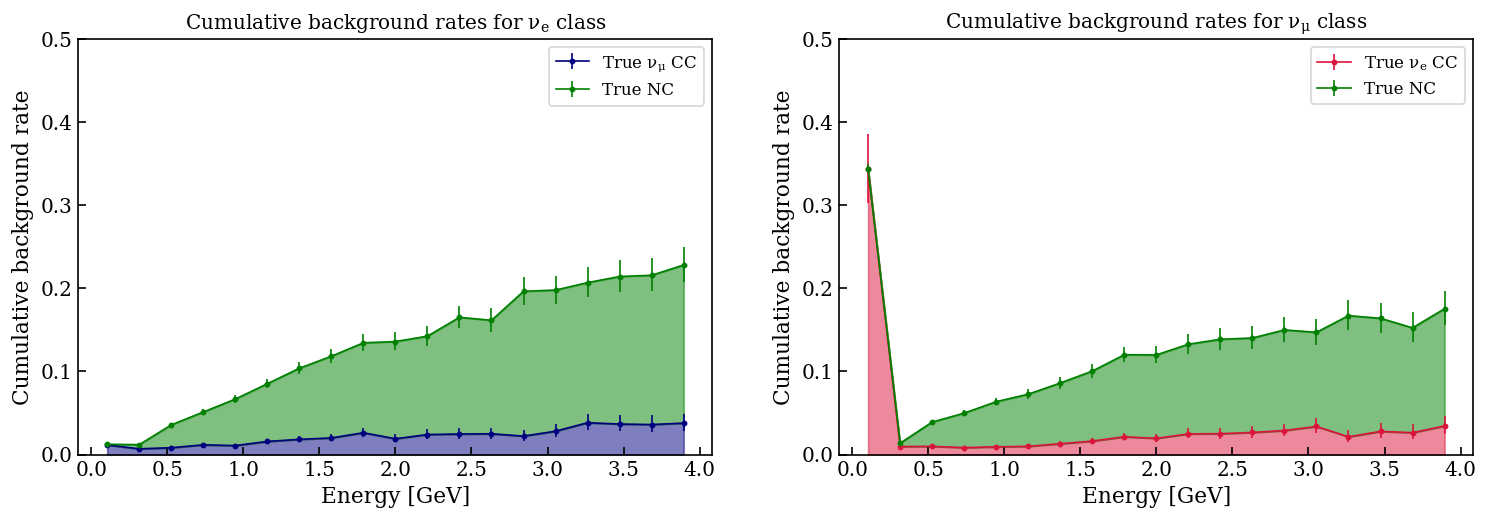

In [235]:
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
bg_nc_fraction = np.zeros((len(e_means),3)) # one purity for each flavor 
bg_cc_fraction = np.zeros((len(e_means),3)) # one purity for each flavor 
sigma_nc_bgs = np.zeros((2,len(e_means), 3))
sigma_cc_bgs = np.zeros((2,len(e_means), 3))

fig, axs = plt.subplots(1, 2, figsize=(15,4.5))

for j, (pred_mask, true_mask) in enumerate(zip(pred_masks, true_masks)):
    if j==0: continue
    ax = axs[j-1] 
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask # predicted AND true events 
        n = pred_mask * e_mask# total PREDICTED events 
        nccount = sum(e_mask * pred_mask * true_nc)
        nuecount = sum(e_mask * pred_mask * true_cc_nu_e)
        numucount = sum(e_mask * pred_mask * true_cc_nu_mu)
        bg_nc_fraction[i,j] = nccount/sum(n)#NC eff 
        if j==1: # nue case: 
            bg_cc_fraction[i,j] = numucount/sum(n)
            sigma_bg_cc = [binomtest(numucount, sum(n)).proportion_ci().low, binomtest(numucount, sum(n)).proportion_ci().high]
            labeler = 'True $\\nu_\\mu$ CC'
            colorer = 'navy'
            titler = '$\\nu_e$'
        if j==2: # numu case: 
            bg_cc_fraction[i,j] = nuecount/sum(n)
            sigma_bg_cc = [binomtest(nuecount, sum(n)).proportion_ci().low, binomtest(nuecount, sum(n)).proportion_ci().high]
            labeler = 'True $\\nu_e$ CC'
            colorer = 'crimson'
            titler = '$\\nu_\\mu$'
        sigma_cc_bgs[:,i,j] = np.abs(sigma_bg_cc- bg_cc_fraction[i,j])
        sigma_bg_nc = [binomtest(nccount, sum(n)).proportion_ci().low, binomtest(nccount, sum(n)).proportion_ci().high]
        sigma_nc_bgs[:,i,j] = np.abs(sigma_bg_nc- bg_nc_fraction[i,j])    
    

    ax.errorbar(e_means, bg_cc_fraction[:,j], yerr = sigma_cc_bgs[:,:,j], label=labeler, 
                linewidth=1, marker='.', color=colorer)
    ax.fill_between(e_means, 0, bg_cc_fraction[:,j], color=colorer, alpha=0.5)
    ax.errorbar(e_means, bg_nc_fraction[:,j]+bg_cc_fraction[:,j], yerr = sigma_nc_bgs[:,:,j], 
                 label='True NC', linewidth=1, marker='.', color='green', 
               )
    ax.fill_between(e_means, bg_cc_fraction[:,j], bg_nc_fraction[:,j]+bg_cc_fraction[:,j], color='green', alpha=0.5)
    ax.set(ylabel='Cumulative background rate', xlabel='Energy [GeV]', ylim=(0, 0.5), 
           title='Cumulative background rates for %s class'%(titler))
    ax.legend(loc='upper right')
plt.savefig('model_eval_plots/%s/bg_contribution_rates_%s_def.pdf'%(model_name, decision_label))

plt.show()

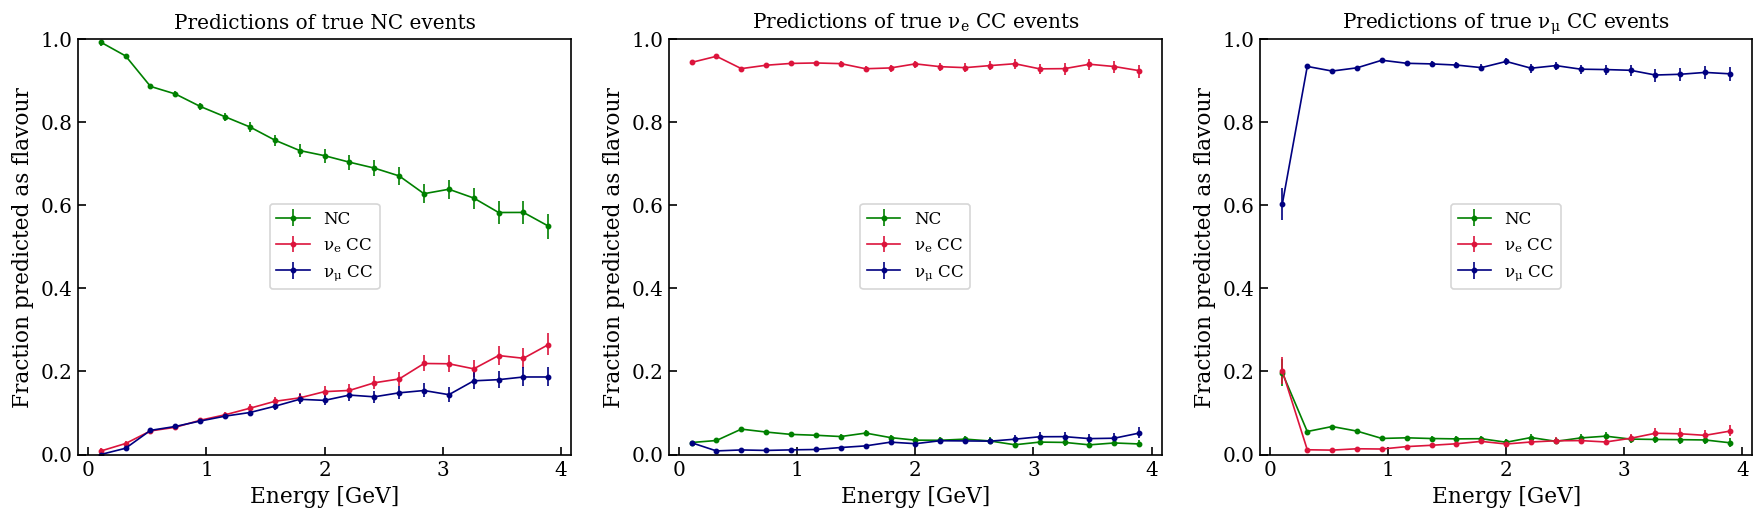

In [242]:
# aaron request: show the fraction of each true class predicted as each of the 3 classes as a function of energy 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros((len(e_means),3))
sigma_effs = np.zeros((2,len(e_means), 3))

fig, axs = plt.subplots(1, 3, figsize=(18,4.5))

#for each ax which denominator is the true flavour 
for k, (ax, true_mask) in enumerate(zip(axs, true_masks)): 
    ax.set(ylim=(0, 1), ylabel='Fraction predicted as flavour', xlabel='Energy [GeV]', 
           title='Predictions of true %s events'%(key_labels['flavour'][k]))
    
    for j, pred_mask in enumerate(pred_masks):
        for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
            e_mask = true_meta['NuEnergy'] >= e_min
            e_mask &= true_meta['NuEnergy'] < e_max

            k = true_mask * e_mask * pred_mask # predicted AND true events 
            n = true_mask * e_mask# total true events 
            if sum(n)>0: 
                effs[i,j] = sum(k)/(sum(n)+1e-5)#NC eff 
            else: 
                effs[i,j] = np.nan
            sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
            sigma_effs[:,i,j] = np.abs(sigma_eff- effs[i,j])
        ax.errorbar(e_means, effs[:,j], yerr = sigma_effs[:,:,j], 
                     label=key_labels['flavour'][j], color=colors[j], linewidth=1, marker='.')
    
    
    ax.legend(loc='center')
# for ax in axs.flat:
#     ax.label_outer()
plt.savefig('model_eval_plots/%s/frac_in_each_class_%s_def.pdf'%(model_name, decision_label))


plt.show()

## Pixel maps for predictions 

In [87]:
pred_flavours = np.where(is_pred_nu_e, 1, 0)
pred_flavours[is_pred_nu_mu] = 2

In [75]:
def get_pixels_map(df, index):
    cells, planes, views = 200,200,3
    with open(df.iloc[index]['image_path'], 'rb') as f:
        file = f.read()
    pixels_map = np.frombuffer(zlib.decompress(file), dtype=np.uint8)
    pixels_map = pixels_map.reshape(views, planes, cells)
    return pixels_map

In [ ]:
    maps_temp, labels_temp = self.get_data_and_labels(indexes)
    maps_z_view = np.asarray(maps_temp)[:, 2:]
    maps_v_view = np.asarray(maps_temp)[:, 1:2]
    maps_u_view = np.asarray(maps_temp)[:, 0:1]

    train_temp = []
    if self.n_channels == 1:
        for i in range(len(maps_z_view)):
            train_temp.append(maps_z_view[i][0])

    elif self.n_channels == 3:
        for i in range(len(maps_z_view)):
            train_temp.append(np.dstack((maps_u_view[i][0], maps_v_view[i][0], maps_z_view[i][0])))
    train_temp = np.array(train_temp).reshape([self.batch_size, self.dim[0], self.dim[1], self.n_channels])

In [76]:
cmap = plt.get_cmap('gnuplot')

# Create a copy of the colormap
new_cmap = cmap.copy()

# Set the color for 0 to white
new_cmap.set_under(color='white')


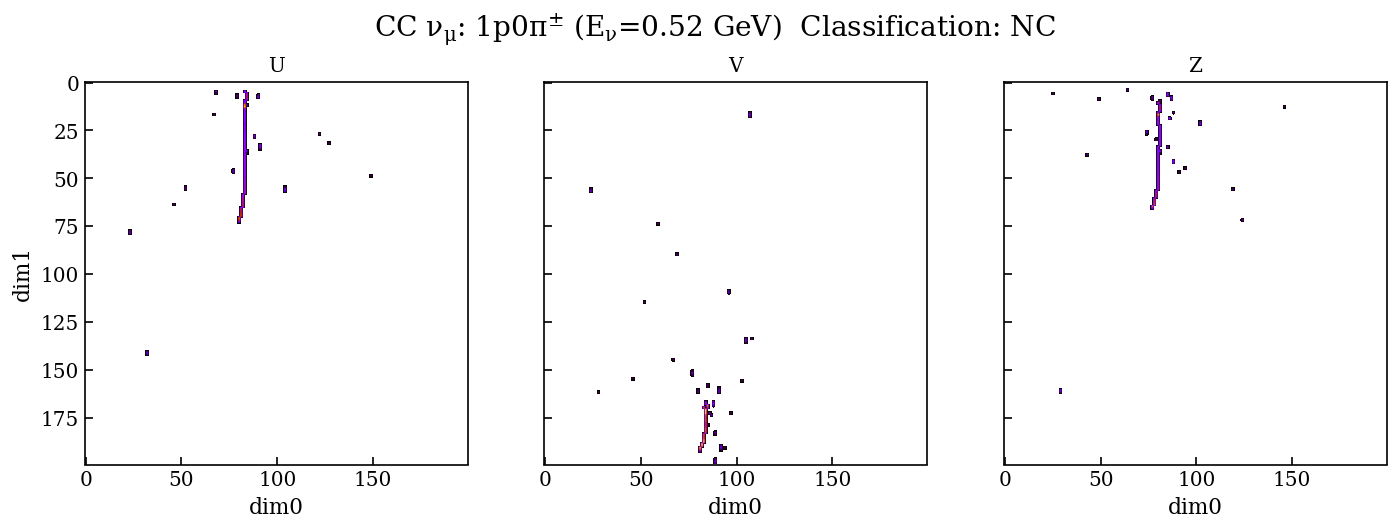

In [191]:
indx = 33
mask = is_cc_numu * ~is_pred_nu_mu
map_to_plot = get_pixels_map(true_meta[mask], indx)
labels = true_meta[mask].iloc[indx]
flav = labels['flavour']
prot = labels['protons']
pions = labels['pions']
flav_labels = ['NC', 'CC $\\nu_e$', 'CC $\\nu_\\mu$']
titles = ['U', 'V', 'Z']
fig, axs = plt.subplots(1, 3, figsize=(14,4.5))

cmap = plt.get_cmap('gnuplot')
cmap.set_bad(color='white', alpha=1)

# masked_maps = np.ma.masked_where(maps[indx] == 0, maps[indx])

for i, ax in enumerate(axs): 
    
    ax.imshow(map_to_plot[i,:,:], cmap=new_cmap, vmin=0.00001)
    # ax.imshow(masked_maps[:, :, i], cmap=cmap, vmin=0)
    # ax.imshow()
    ax.set(xlabel='dim0', ylabel='dim1',title=titles[i])
for ax in axs.flat:
    ax.label_outer()
fig.suptitle('%s: %ip%i$\\pi^{\\pm}$ (E$_\\nu$=%.2f GeV)  Classification: %s'%(flav_labels[flav], prot, 
                                                                        pions, labels['NuEnergy'], 
                                                                        flav_labels[pred_flavours[mask][indx]]
                                                                       ))
plt.savefig('model_eval_plots/%s/pixel_maps/pixel_maps_flav%s_pred%s_%s.pdf'%(model_name,flav,pred_flavours[mask][indx], indx))
plt.show()

## Interaction type distributions

In [63]:
def get_interaction(df): 
    intcode = df['Interaction']
    
    intcode = np.where(df['flavour']==0, -1, intcode)
    return intcode

In [64]:
interaction_code = get_interaction(true_meta)

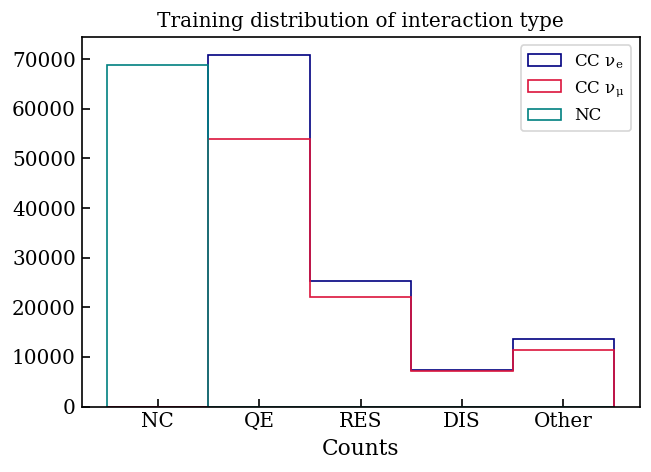

In [66]:
bins = plt.hist(interaction_code[true_meta['flavour']==1], bins=np.arange(-1,5), histtype='step', label='CC $\\nu_e$')
plt.hist(interaction_code[true_meta['flavour']==2], bins=bins[1], histtype='step', label='CC $\\nu_\\mu$')
plt.hist(interaction_code[true_meta['flavour']==0], bins=bins[1], histtype='step', label='NC')
plt.xticks(bins[1][1:]-0.5, ['NC', 'QE', 'RES', 'DIS', 'Other'])
plt.legend()
# plt.yscale('log')
plt.xlabel('Counts')
plt.title('Training distribution of interaction type')
plt.savefig('model_eval_plots/%s/interaction_type_prior_distribution.pdf'%(model_name))
plt.show()

In [221]:
is_pred_nu_e = cc_nue_mask(flav_preds, nue_bound)
is_pred_nu_mu_prelim = cc_numu_mask(flav_preds, numu_bound)
is_pred_nu_mu = ~is_pred_nu_e * is_pred_nu_mu_prelim

true_cc_nu_e = true['flavour'] == 1 
true_cc_nu_mu = true['flavour'] == 2 

#interaction types: 
int_labels = ['QE', 'RES', 'DIS', 'Other']
int_masks = [interaction_code==0, interaction_code==1, interaction_code==2, interaction_code==3]

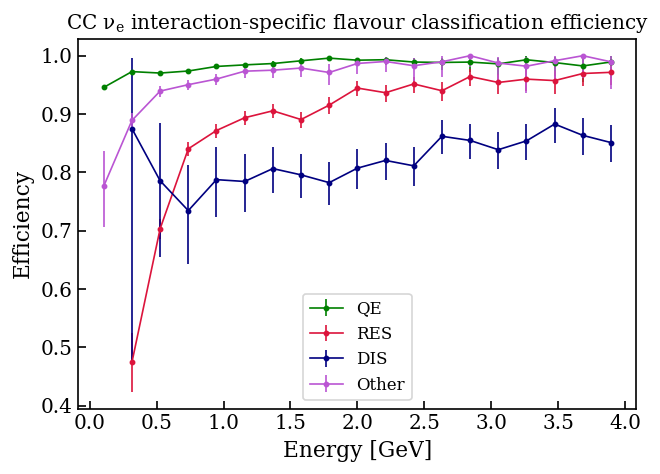

In [222]:
# nu_e interaction-specific efficiency 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros((len(e_means),4))
sigma_effs = np.zeros((2,len(e_means), 4))
# purity = np.zeros((len(e_means),4)) # one purity for each flavor 
true_mask = true_cc_nu_e
pred_mask = is_pred_nu_e
for j, int_mask in enumerate(int_masks):

    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask * int_mask # predicted AND true events 
        n = true_mask * e_mask * int_mask # total true events 
        if sum(n)>0: 
            effs[i,j] = sum(k)/sum(n) 
            sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        else: 
            effs[i,j] = np.nan
            sigma_eff = np.nan
        sigma_effs[:,i,j] = np.abs(sigma_eff- effs[i,j])
    
    plt.errorbar(e_means, effs[:,j], yerr = sigma_effs[:,:,j], 
                 label=int_labels[j], color=colors[j], linewidth=1,marker='.')
plt.legend(loc='lower center')
plt.ylabel('Efficiency')
plt.xlabel('Energy [GeV]')
plt.title('CC $\\nu_e$ interaction-specific flavour classification efficiency')
plt.savefig('model_eval_plots/%s/efficiency_energy_interaction_specific_%s_%s.pdf'%(model_name, 'nue', decision_label))
plt.show()

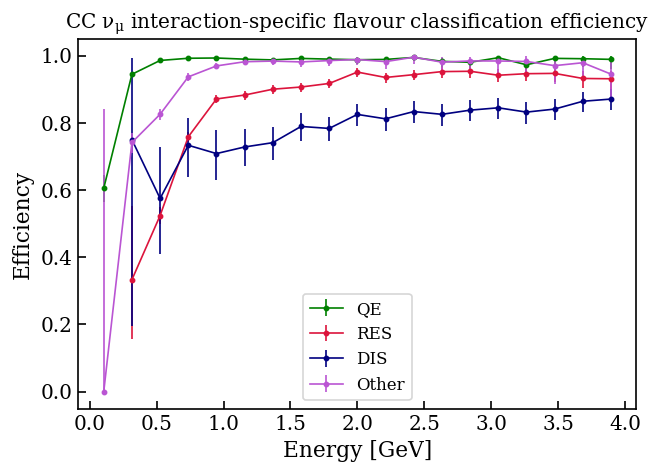

In [223]:
# nu_e interaction-specific efficiency 
e_bins = np.linspace(0,4,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros((len(e_means),4))
sigma_effs = np.zeros((2,len(e_means), 4))
# purity = np.zeros((len(e_means),4)) # one purity for each flavor 
true_mask = true_cc_nu_mu
pred_mask = is_pred_nu_mu
for j, int_mask in enumerate(int_masks):

    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = true_meta['NuEnergy'] >= e_min
        e_mask &= true_meta['NuEnergy'] < e_max

        k = true_mask * e_mask * pred_mask * int_mask # predicted AND true events 
        n = true_mask * e_mask * int_mask # total true events 
        if sum(n)>0: 
            effs[i,j] = sum(k)/(sum(n)+1e-5) 
            sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        else: 
            effs[i,j] = np.nan
            sigma_eff = np.nan
        sigma_effs[:,i,j] = np.abs(sigma_eff- effs[i,j])
    
    plt.errorbar(e_means, effs[:,j], yerr = sigma_effs[:,:,j], 
                 label=int_labels[j], color=colors[j], linewidth=1, marker='.')
plt.legend(loc='lower center')
plt.ylabel('Efficiency')
plt.xlabel('Energy [GeV]')
plt.title('CC $\\nu_\\mu$ interaction-specific flavour classification efficiency')
plt.savefig('model_eval_plots/%s/efficiency_energy_interaction_specific_%s_%s.pdf'%(model_name, 'numu', decision_label))
plt.show()

## Misc 

In [68]:
# efficiency as a function of lepton angle  
bound = xs[np.argmax(fom)] #0.372 
e_bins = np.linspace(-1,1,20)
e_means = (e_bins[:-1]+e_bins[1:])/2
effs = np.zeros_like(e_means)
sigma_effs = np.zeros((2,len(e_means)))

for flav in [1,2]:
    for i, (e_min, e_max) in enumerate(zip(e_bins[:-1], e_bins[1:])):
        e_mask = np.cos(true_meta['LepAngle']) >= e_min
        e_mask &= np.cos(true_meta['LepAngle']) < e_max
        true_in_e = true[e_mask]
        true_cc_in_e = true_in_e['flavour']==flav
        pred_in_e = flav_preds[e_mask]
        pred_cc_in_e = nc_mask(pred_in_e, bound)
        # pred_cc_in_e = pred_in_e[:,f] > bound
        n = sum(true_cc_in_e)# total
        k = sum(pred_cc_in_e * true_cc_in_e) # accepted true CC events
        effs[i] = k/(n+1e-2)
        sigma_eff = [binomtest(sum(k), sum(n)).proportion_ci().low, binomtest(sum(k), sum(n)).proportion_ci().high]
        sigma_effs[:,i] = np.abs(sigma_eff- effs[i])
    plt.errorbar(e_means, effs, yerr = sigma_effs, 
                 label=key_labels['flavour'][flav], color=colors[flav], linewidth=1, marker='.')
plt.legend(loc='lower right')
plt.ylabel('Efficiency')
plt.xlabel('cos($\\theta_{\\ell}$)')
plt.title('Flavour-specific efficiency of optimized CVN boundary')
# plt.savefig('model_eval_plots/%s/ncdef_efficiency_theta_l.pdf'%(model_name))

plt.show()        

NameError: name 'fom' is not defined